In [1]:
import time, matplotlib, sklearn
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 
import seaborn as sns
import torch
import pickle, joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, SMOTENC

# Load data

In [2]:
# description
description = pd.read_csv('./WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('./training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [3]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
description_dict['immunosuppression']

{'Category': 'APACHE comorbidity',
 'Unit of Measure': nan,
 'Data Type': 'binary',
 'Description': 'Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).',
 'Example': '1'}

# Data Exploration and Preprocessing

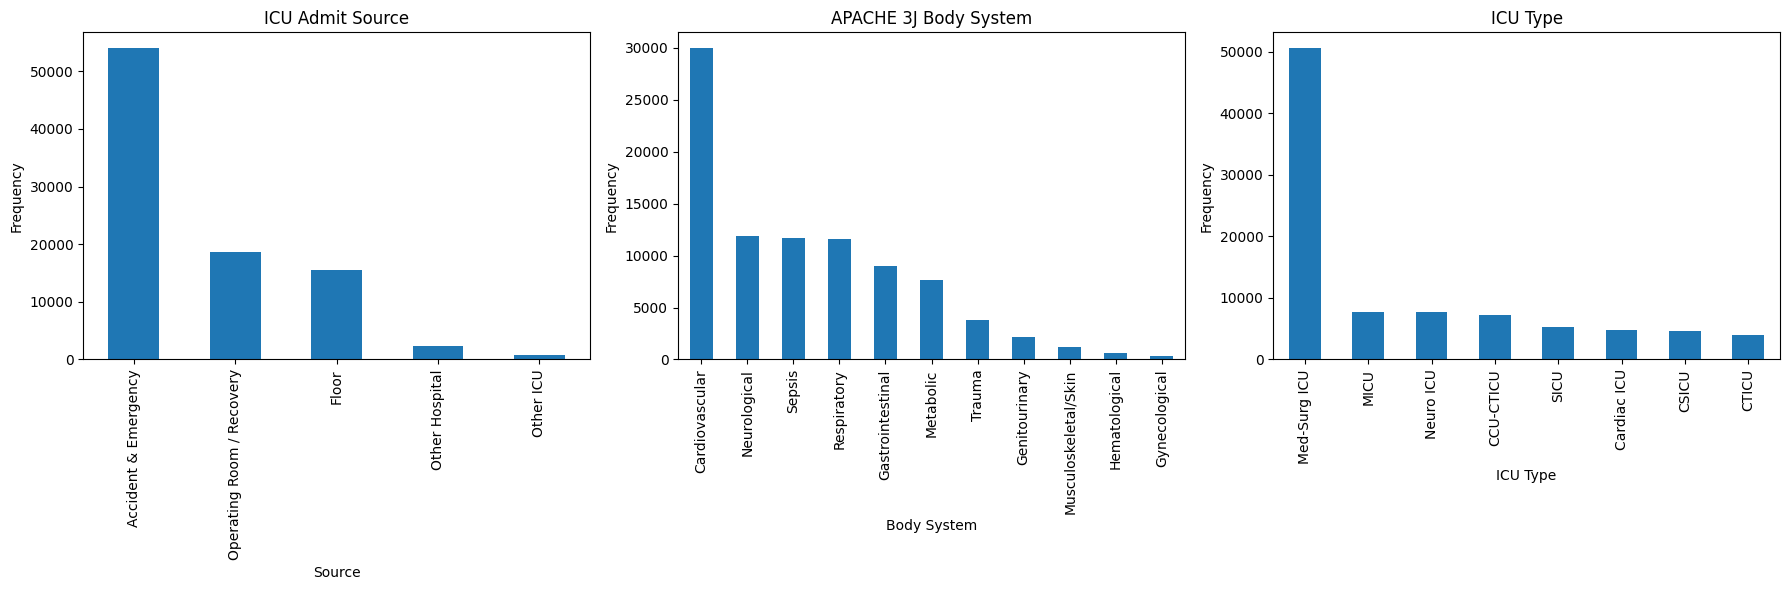

In [4]:
# Creating the grid of histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting icu_admit_source histogram
df['icu_admit_source'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('ICU Admit Source')
axes[0].set_xlabel('Source')
axes[0].set_ylabel('Frequency')

# Plotting apache_3j_bodysystem histogram
df['apache_3j_bodysystem'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('APACHE 3J Body System')
axes[1].set_xlabel('Body System')
axes[1].set_ylabel('Frequency')

# Plotting icu_type histogram
df['icu_type'].value_counts().plot(kind='bar', ax=axes[2])
axes[2].set_title('ICU Type')
axes[2].set_xlabel('ICU Type')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [5]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values for a column to be dropped

In [6]:
# from the dictionary, append what type of data each feature is for labs and vitals
# Load the dictionary CSV file
dictionary = pd.read_csv('./WiDS_Datathon_2020_Dictionary.csv')

# Filter dictionary to get columns related to "vitals" or "labs"
vitals_labs_columns = dictionary[dictionary['Category'].str.contains('vitals|labs', case=False, na=False)]

# Create a mapping of original column names to new column names
column_mapping = {}
for _, row in vitals_labs_columns.iterrows():
    if row['Category'].lower().startswith('vitals'):
        column_mapping[row['Variable Name']] = f"vitals_{row['Variable Name']}"
    elif row['Category'].lower().startswith('labs'):
        column_mapping[row['Variable Name']] = f"labs_{row['Variable Name']}"

# Rename the columns in your DataFrame
df.rename(columns=column_mapping, inplace=True)

In [7]:
# remove rows with -1 values from APACHE scores
df = df[df['apache_4a_hospital_death_prob'] != -1] 

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)
# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

X

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,labs_h1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
0,68.0,22.730000,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis
1,77.0,27.420000,0,Caucasian,F,160.0,Floor,Floor,admit,Med-Surg ICU,...,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory
2,25.0,31.950000,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic
3,81.0,22.640000,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,admit,CTICU,...,337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular
4,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,admit,Med-Surg ICU,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.0,23.060250,0,Caucasian,M,177.8,Acute Care/Floor,Floor,admit,Cardiac ICU,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis
91709,56.0,47.179671,0,Caucasian,F,183.0,Emergency Department,Floor,admit,Med-Surg ICU,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis
91710,48.0,27.236914,0,Caucasian,M,170.2,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic
91711,NaN,23.297481,0,Caucasian,F,154.9,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory


In [8]:
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 


Missing values:
labs_h1_bilirubin_max    82427
labs_h1_bilirubin_min    82427
labs_h1_lactate_max      82175
labs_h1_lactate_min      82175
labs_h1_albumin_min      81645
dtype: int64


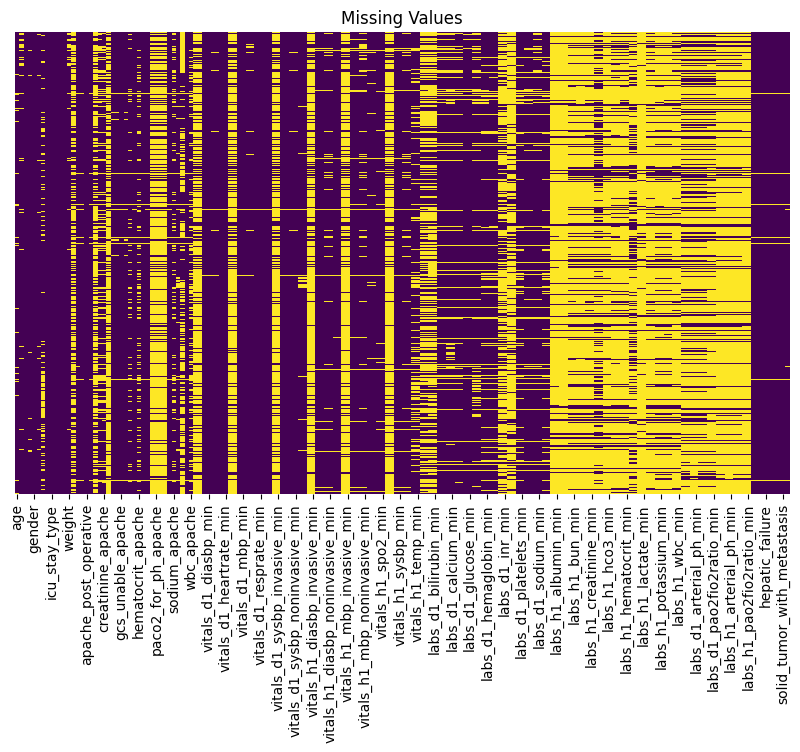

In [9]:
# First we can check for the missing values. Based on that an imputer can be used, or just remove the missing values.
# This depends on the amount of missing values obtained
values_missing = X.isnull().sum().sort_values(ascending=False) #check

# print the missing values (head only)
print("\nMissing values:")
print(values_missing.head(5))

# Visualize
plt.figure(figsize=(10,6))
sns.heatmap(X.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values")
plt.show()

## Pre-process

Plotting histograms for 96 columns in a 32x3 grid.


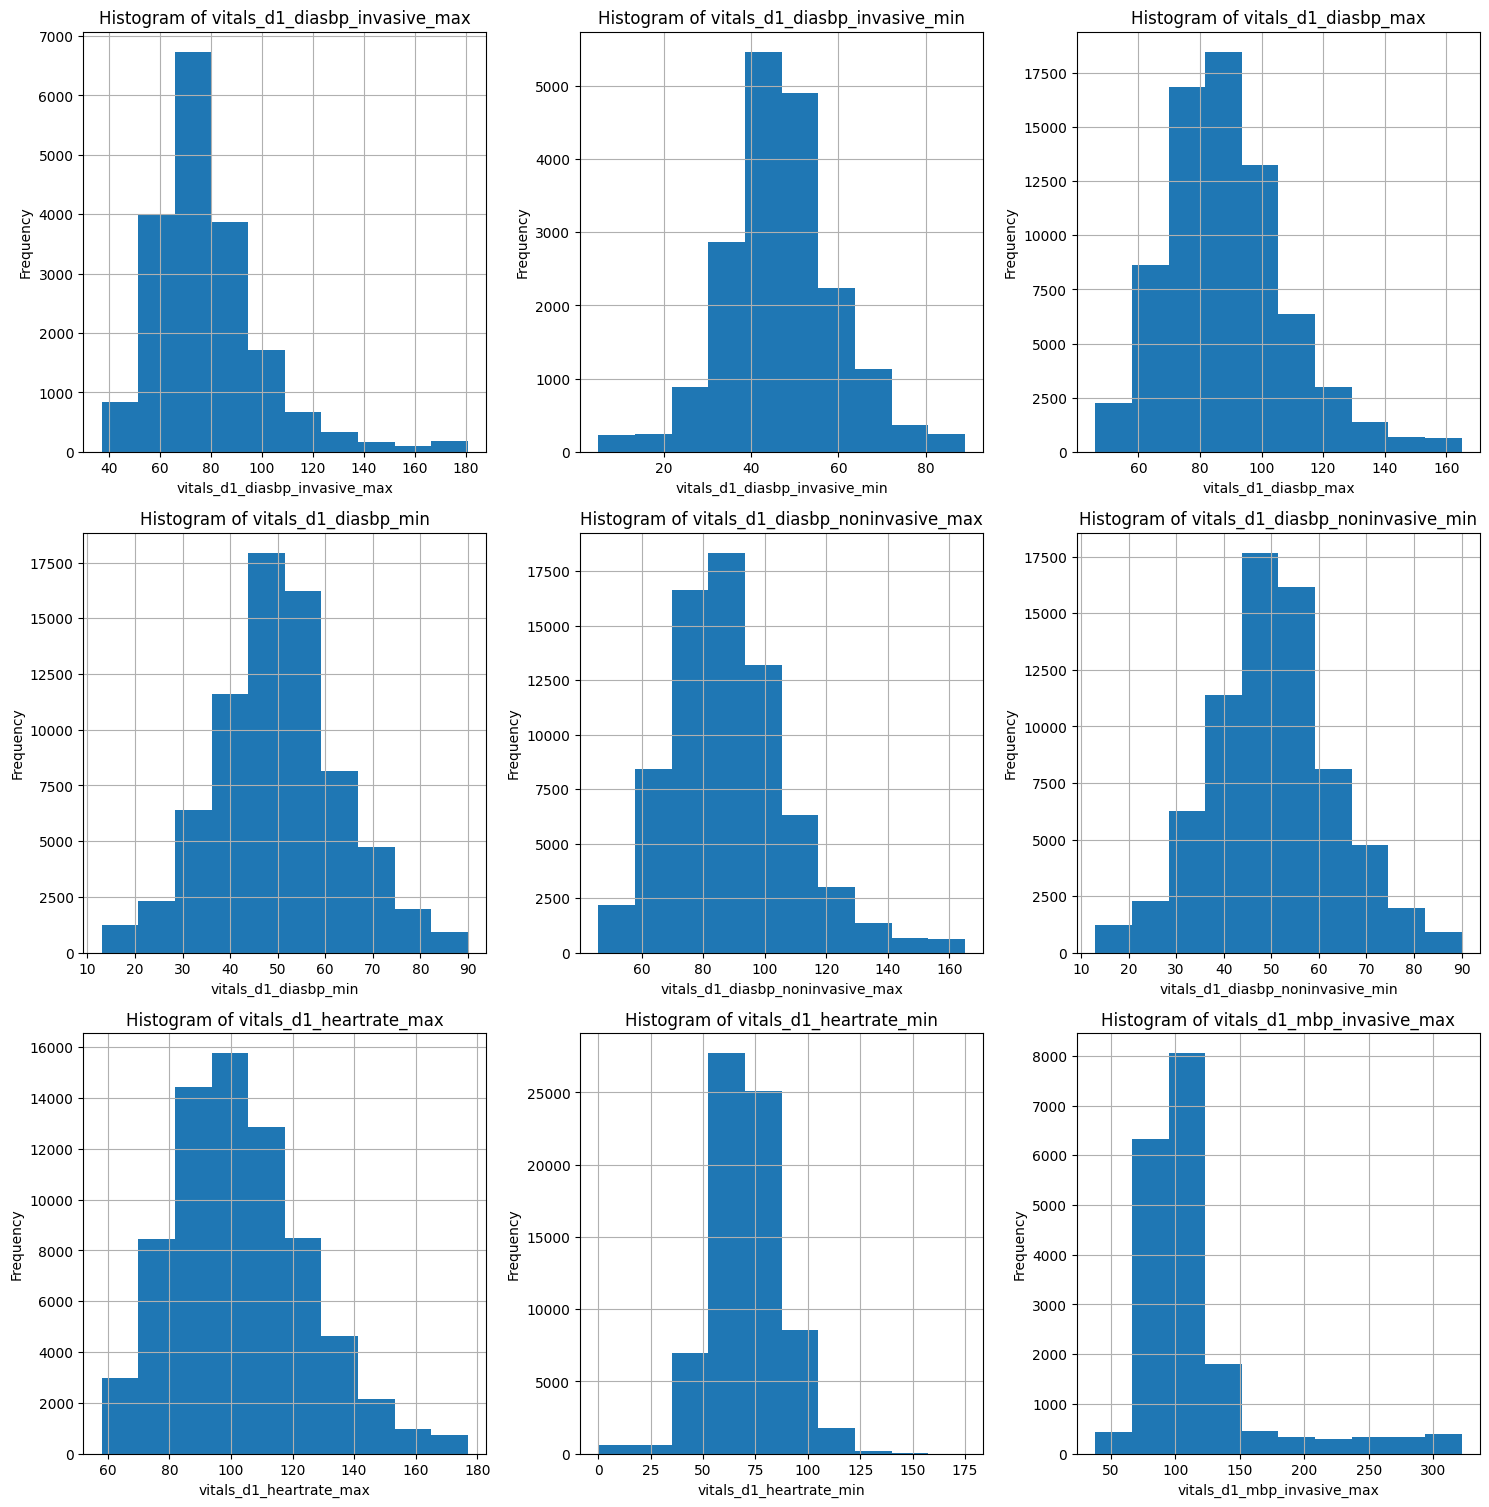

In [10]:
# Drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)


# Filter columns that contain "vitals" or "labs" in their names
vitals_labs_columns = [col for col in X_train.columns if "vitals" in col or "labs" in col]

# Check if any columns were found
if not vitals_labs_columns:
    print("No columns containing 'vitals' or 'labs' found.")
else:
    # Plot histograms for these columns in a grid
    num_cols = 3  # Number of columns in the grid
    num_rows = (len(vitals_labs_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed
    print(f"Plotting histograms for {len(vitals_labs_columns)} columns in a {num_rows}x{num_cols} grid.")

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(vitals_labs_columns[:9]):
        X_train[col].hist(bins=10, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Most values have normal distribution, and should be imputed with average <br>
But some values have a different distribution, and they should use median

In [11]:
# define pre-processing steps for numerical features
from sklearn.preprocessing import OneHotEncoder, StandardScaler


num_transformer = Pipeline(steps=[
    ("constant", VarianceThreshold()),  # remove constant features
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Define preprocessing steps for categorical features
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder())
])

# Create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)),  # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object))  # apply to columns of type object
    ])

# Fit the pipeline
prep_pipeline.fit(X_train, y_train)

# Transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())

# Print stats
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

dfoo = pd.DataFrame(X_train)

# Select the first 10 rows
dfoo_head = dfoo.head(10)

# Rotate column labels by 90 degrees
styled_dfoo = dfoo_head.style.set_table_styles(
    [{'selector': 'th', 'props': [('max-width', '80px')]},
     {'selector': 'th.col_heading', 'props': [('transform', 'rotate(-90deg)'), 
                                              ('text-align', 'left'), 
                                              ('white-space', 'nowrap'),
                                              ('height', '150px')]}]
)
# Display the styled DataFrame
styled_dfoo


Train set: 71473 rows, 193 columns
Validation set: 8934 rows, 193 columns
Test set: 8935 rows, 193 columns


,num__age,num__bmi,num__elective_surgery,num__height,num__pre_icu_los_days,num__weight,num__albumin_apache,num__apache_2_diagnosis,num__apache_3j_diagnosis,num__apache_post_operative,num__arf_apache,num__bilirubin_apache,num__bun_apache,num__creatinine_apache,num__fio2_apache,num__gcs_eyes_apache,num__gcs_motor_apache,num__gcs_unable_apache,num__gcs_verbal_apache,num__glucose_apache,num__heart_rate_apache,num__hematocrit_apache,num__intubated_apache,num__map_apache,num__paco2_apache,num__paco2_for_ph_apache,num__pao2_apache,num__ph_apache,num__resprate_apache,num__sodium_apache,num__temp_apache,num__urineoutput_apache,num__ventilated_apache,num__wbc_apache,num__vitals_d1_diasbp_invasive_max,num__vitals_d1_diasbp_invasive_min,num__vitals_d1_diasbp_max,num__vitals_d1_diasbp_min,num__vitals_d1_diasbp_noninvasive_max,num__vitals_d1_diasbp_noninvasive_min,num__vitals_d1_heartrate_max,num__vitals_d1_heartrate_min,num__vitals_d1_mbp_invasive_max,num__vitals_d1_mbp_invasive_min,num__vitals_d1_mbp_max,num__vitals_d1_mbp_min,num__vitals_d1_mbp_noninvasive_max,num__vitals_d1_mbp_noninvasive_min,num__vitals_d1_resprate_max,num__vitals_d1_resprate_min,num__vitals_d1_spo2_max,num__vitals_d1_spo2_min,num__vitals_d1_sysbp_invasive_max,num__vitals_d1_sysbp_invasive_min,num__vitals_d1_sysbp_max,num__vitals_d1_sysbp_min,num__vitals_d1_sysbp_noninvasive_max,num__vitals_d1_sysbp_noninvasive_min,num__vitals_d1_temp_max,num__vitals_d1_temp_min,num__vitals_h1_diasbp_max,num__vitals_h1_diasbp_min,num__vitals_h1_diasbp_noninvasive_max,num__vitals_h1_diasbp_noninvasive_min,num__vitals_h1_heartrate_max,num__vitals_h1_heartrate_min,num__vitals_h1_mbp_max,num__vitals_h1_mbp_min,num__vitals_h1_mbp_noninvasive_max,num__vitals_h1_mbp_noninvasive_min,num__vitals_h1_resprate_max,num__vitals_h1_resprate_min,num__vitals_h1_spo2_max,num__vitals_h1_spo2_min,num__vitals_h1_sysbp_max,num__vitals_h1_sysbp_min,num__vitals_h1_sysbp_noninvasive_max,num__vitals_h1_sysbp_noninvasive_min,num__vitals_h1_temp_max,num__vitals_h1_temp_min,num__labs_d1_albumin_max,num__labs_d1_albumin_min,num__labs_d1_bilirubin_max,num__labs_d1_bilirubin_min,num__labs_d1_bun_max,num__labs_d1_bun_min,num__labs_d1_calcium_max,num__labs_d1_calcium_min,num__labs_d1_creatinine_max,num__labs_d1_creatinine_min,num__labs_d1_glucose_max,num__labs_d1_glucose_min,num__labs_d1_hco3_max,num__labs_d1_hco3_min,num__labs_d1_hemaglobin_max,num__labs_d1_hemaglobin_min,num__labs_d1_hematocrit_max,num__labs_d1_hematocrit_min,num__labs_d1_inr_max,num__labs_d1_inr_min,num__labs_d1_lactate_max,num__labs_d1_lactate_min,num__labs_d1_platelets_max,num__labs_d1_platelets_min,num__labs_d1_potassium_max,num__labs_d1_potassium_min,num__labs_d1_sodium_max,num__labs_d1_sodium_min,num__labs_d1_wbc_max,num__labs_d1_wbc_min,num__labs_h1_glucose_max,num__labs_h1_glucose_min,num__labs_h1_hemaglobin_max,num__labs_h1_hemaglobin_min,num__labs_h1_hematocrit_max,num__labs_h1_hematocrit_min,num__labs_h1_inr_max,num__labs_h1_inr_min,num__labs_h1_potassium_max,num__labs_h1_potassium_min,num__labs_h1_sodium_max,num__labs_h1_sodium_min,num__labs_d1_arterial_pco2_max,num__labs_d1_arterial_pco2_min,num__labs_d1_arterial_ph_max,num__labs_d1_arterial_ph_min,num__labs_d1_arterial_po2_max,num__labs_d1_arterial_po2_min,num__labs_d1_pao2fio2ratio_max,num__labs_d1_pao2fio2ratio_min,num__aids,num__cirrhosis,num__diabetes_mellitus,num__hepatic_failure,num__immunosuppression,num__leukemia,num__lymphoma,num__solid_tumor_with_metastasis,cat__ethnicity_African American,cat__ethnicity_Asian,cat__ethnicity_Caucasian,cat__ethnicity_Hispanic,cat__ethnicity_Native American,cat__ethnicity_Other/Unknown,cat__ethnicity_missing,cat__gender_F,cat__gender_M,cat__gender_missing,cat__hospital_admit_source_Acute Care/Floor,cat__hospital_admit_source_Chest Pain Center,cat__hospital_admit_source_Direct Admit,cat__hospital_admit_source_Emergency Department,cat__hospital_admit_source_Floor,cat__hospital_admit_source_ICU,cat__hospital_admit_source_ICU to SDU,cat__hospital_ad

We will drop highly correlated features based on a correlation threshold. 

In [12]:
CORR_THRESHOLD = 0.975
# extratc highly correlated columns
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# exclude columns containg gender and ethnicty, we need them during fairness evaluation
to_drop = [column for column in upper.columns if any(upper[column] > CORR_THRESHOLD)]
protected_columns = [column for column in to_drop if 'gender' in column.lower() or 'ethnicity' in column.lower()]
final_to_drop = [column for column in to_drop if column not in protected_columns]

print("Initially identified columns for dropping:", to_drop)
print("Protected columns kept:", protected_columns)
print("Final dropped columns:", final_to_drop)

# drop them
X_train_reduced = X_train.drop(columns=final_to_drop, errors='ignore')
X_val_reduced = X_val.drop(columns=final_to_drop, errors='ignore')
X_test_reduced = X_test.drop(columns=final_to_drop, errors='ignore')

Initially identified columns for dropping: ['num__paco2_for_ph_apache', 'num__vitals_d1_diasbp_noninvasive_max', 'num__vitals_d1_diasbp_noninvasive_min', 'num__vitals_d1_mbp_noninvasive_min', 'num__vitals_d1_sysbp_noninvasive_max', 'num__vitals_d1_sysbp_noninvasive_min', 'num__vitals_h1_mbp_noninvasive_min', 'num__vitals_h1_sysbp_noninvasive_max', 'num__labs_d1_bilirubin_min', 'num__labs_h1_inr_max', 'num__labs_h1_inr_min', 'cat__gender_M']
Protected columns kept: ['cat__gender_M']
Final dropped columns: ['num__paco2_for_ph_apache', 'num__vitals_d1_diasbp_noninvasive_max', 'num__vitals_d1_diasbp_noninvasive_min', 'num__vitals_d1_mbp_noninvasive_min', 'num__vitals_d1_sysbp_noninvasive_max', 'num__vitals_d1_sysbp_noninvasive_min', 'num__vitals_h1_mbp_noninvasive_min', 'num__vitals_h1_sysbp_noninvasive_max', 'num__labs_d1_bilirubin_min', 'num__labs_h1_inr_max', 'num__labs_h1_inr_min']


Check for class imbalance


Class distribution is:
hospital_death
0    0.913758
1    0.086242
Name: proportion, dtype: float64


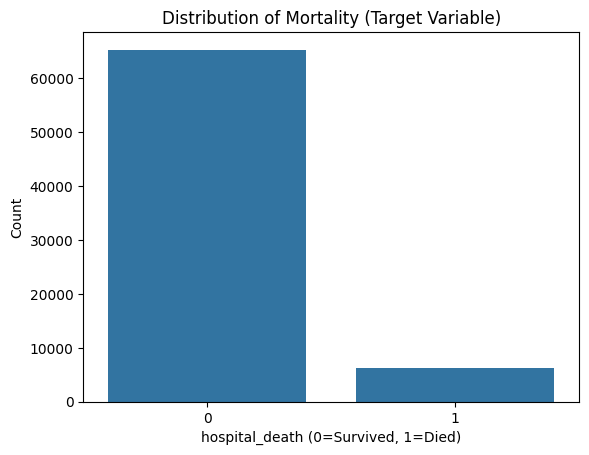

In [13]:
# target variable distribution
print("\nClass distribution is:")
print(y_train.value_counts(normalize=True))

# plot distribution
sns.countplot(x=y_train)
plt.title("Distribution of Mortality (Target Variable)")
plt.xlabel("hospital_death (0=Survived, 1=Died)")
plt.ylabel("Count")
plt.show()

Since we notice a clear imbalance in positives vs negatives, we oversample the number of negative examples using SMOTE


Class distribution is:
hospital_death
0    0.66667
1    0.33333
Name: proportion, dtype: float64


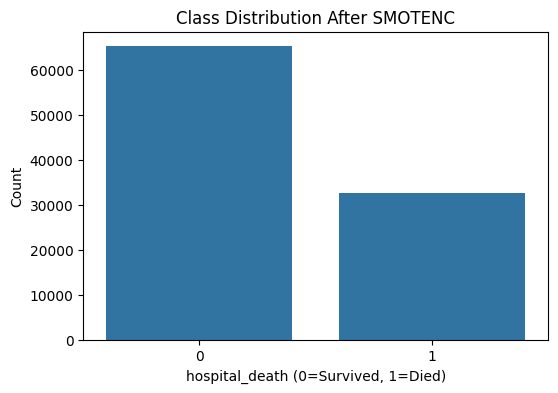

In [14]:
cat_features = [i for i, col in enumerate(X_train_reduced.columns) if col.startswith("cat_")]
smotenc = SMOTENC(categorical_features=cat_features, sampling_strategy=0.5, random_state=42)  
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train_reduced, y_train)

# target variable distribution
print("\nClass distribution is:")
print(y_train_resampled.value_counts(normalize=True))

# plot distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTENC")
plt.xlabel("hospital_death (0=Survived, 1=Died)")
plt.ylabel("Count")
plt.show()

Although not equal, the relation of positive to negative samples is a bit more balanced.

# Training


To train our candidate models, we run a grid search within a stratified k-fold cross validation training approach for each model. This approach explores a predefined hyperparameter space to identify the optimal model configuration, while ensuring that each fold maintains the same class distribution as the overall dataset. Using stratified k-fold is particularly beneficial for imbalanced datasets, as it helps mitigate bias and provides more reliable performance estimates compared to regular k-fold cross validation.

We use this strategy to select the model that performs best, which will then be used for fairness and explainability assesment

## Neural Network

Define an equalized-odds fairness metric that can be used during the grid search to select the best model. We consider the ethnicity and gender as sensitive features. We first decode them from the one-hot encoding and then asses them using the fairlearn library

In [15]:
def decode_sensitive_attribute(df, prefix):
    # select all one-hot columns for this feature
    cols = [col for col in df.columns if col.startswith(prefix)]
    # extarct the column with value 1
    decoded = df[cols].idxmax(axis=1)
    decoded = decoded.str.replace(prefix, "", regex=False)
    return decoded


def custom_eo_scorer(estimator, X, y, sensitive_prefix):
    sensitive_features = decode_sensitive_attribute(X, sensitive_prefix)

    y_pred = estimator.predict(X.values)
    eo_diff = equalized_odds_difference(
        y_true=y,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    # negative value so that lower differences mean a higher score
    return -eo_diff

def custom_dp_scorer(estimator, X, y, sensitive_prefix):
    sensitive_features = decode_sensitive_attribute(X, sensitive_prefix)
    
    y_pred = estimator.predict(X.values)
    dp_diff = demographic_parity_difference(
        y_true=y,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    # negative value so that lower differences means a higher score
    return -dp_diff

In [16]:
def eo_ethnicity(columns):
    def scorer(estimator, X, y):
        X_df = pd.DataFrame(X, columns=columns)
        return custom_eo_scorer(estimator, X_df, y, sensitive_prefix="cat__ethnicity_")
    return scorer

def eo_gender(columns):
    def scorer(estimator, X, y):
        X_df = pd.DataFrame(X, columns=columns)
        return custom_eo_scorer(estimator, X_df, y, sensitive_prefix="cat__gender_")
    return scorer

def dp_ethnicity(columns):
    def scorer(estimator, X, y):
        X_df = pd.DataFrame(X, columns=columns)
        return custom_dp_scorer(estimator, X_df, y, sensitive_prefix="cat__ethnicity_")
    return scorer

def dp_gender(columns):
    def scorer(estimator, X, y):
        X_df = pd.DataFrame(X, columns=columns)
        return custom_dp_scorer(estimator, X_df, y, sensitive_prefix="cat__gender_")
    return scorer

def composite_scorer(columns):
    def scorer(estimator, X, y):
        X_df = pd.DataFrame(X, columns=columns)
        
        # compute accuracy
        y_pred = estimator.predict(X)
        acc = accuracy_score(y, y_pred)

        # FNR at threshold 0.5 - we wamt to keep fnr as low as possible
        y_pred_prob = estimator.predict_proba(X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
        fnr = 1 - tpr
        threshold_idx = np.argmin(np.abs(thresholds - 0.5))
        fnr_at_threshold = fnr[threshold_idx]
        fnr_val = 1 - fnr_at_threshold # higher values are better
        
        # Compute fairness metrics
        eo_eth = custom_eo_scorer(estimator, X_df, y, sensitive_prefix="cat__ethnicity_")
        eo_gen = custom_eo_scorer(estimator, X_df, y, sensitive_prefix="cat__gender_")
        dp_eth = custom_dp_scorer(estimator, X_df, y, sensitive_prefix="cat__ethnicity_")
        dp_gen = custom_dp_scorer(estimator, X_df, y, sensitive_prefix="cat__gender_")
        
        # composite scoring function
        composite_score = 0.4*acc + 0.2*fnr_val + 0.1*eo_eth + 0.1*eo_gen + 0.1*dp_eth + 0.1*dp_gen
        return composite_score
    return scorer

# create EO and DP scorers
columns = X_train_resampled.columns
ethnicity_eo = eo_ethnicity(columns)
gender_eo = eo_gender(columns)
ethnicity_dp = dp_ethnicity(columns)
gender_dp = dp_gender(columns)
composite_score = composite_scorer(columns)

# scoring metrics.
scoring = {
    'accuracy': 'accuracy',
    'eo_ethnicity': ethnicity_eo,
    'eo_gender': gender_eo,
    'dp_ethnicity': ethnicity_dp,
    'dp_gender': gender_dp,
    'composite': composite_score
}

In [17]:
from classifier.nn_wrapper import NNClassifierWrapper
from classifier.nn_classifier import NeuralNetworkClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# hyperparameter grid
param_grid = {
    'hidden_layers': [[64, 32], [64, 64, 32, 16]],
    'epochs': [20],
    'learning_rate': [0.001],
}

# nput_dim is the number of features
input_dim = X_train_resampled.shape[1]

# Create the estimator wrapper 
nn_estimator = NNClassifierWrapper(input_dim=input_dim, verbose=1) 

# Define a cross-validation strategy (using stratified k-fold for classification)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_nn = GridSearchCV(
    nn_estimator,
    param_grid,
    cv=cv_strategy,
    scoring=scoring,
    refit='composite',  # choose composite scoring function for selecting the best model
    verbose=2
)

# Run grid search on the training data
grid_search_nn.fit(X_train_resampled.values, y_train_resampled.values)

print("Best parameters found: ", grid_search_nn.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search_nn.best_score_))

# retrieve best results
results_nn = grid_search_nn.cv_results_
best_index_nn = grid_search_nn.best_index_

# Extract individual scores for the best model
best_accuracy_nn = results_nn['mean_test_accuracy'][best_index_nn]
best_eo_eth_nn = results_nn['mean_test_eo_ethnicity'][best_index_nn]
best_eo_gen_nn = results_nn['mean_test_eo_gender'][best_index_nn]
best_dp_eth_nn = results_nn['mean_test_dp_ethnicity'][best_index_nn]
best_dp_gen_nn = results_nn['mean_test_dp_gender'][best_index_nn]
best_composite_nn = results_nn['mean_test_composite'][best_index_nn]

print("Best composite score:", best_composite_nn)
print("Best Accuracy:", best_accuracy_nn)
print("Best EO (Ethnicity):", -best_eo_eth_nn)
print("Best EO (Gender):", -best_eo_gen_nn)
print("Best DP (Ethnicity):", -best_dp_eth_nn)
print("Best DP (Gender):", -best_dp_gen_nn)

# Save the state dictionary of the best model
torch.save(grid_search_nn.best_estimator_.model_, "models/best_nn_model_oversampled.pth")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Starting training with hyperparameters:
  hidden_layers: [64, 32]
  dropout_rate: 0.2
  learning_rate: 0.001
  epochs: 20
  batch_size: 32
Epoch [1/20], Loss: 0.3035
Epoch [2/20], Loss: 0.2307
Epoch [3/20], Loss: 0.2114
Epoch [4/20], Loss: 0.2011
Epoch [5/20], Loss: 0.1922
Epoch [6/20], Loss: 0.1877
Epoch [7/20], Loss: 0.1824
Epoch [8/20], Loss: 0.1778
Epoch [9/20], Loss: 0.1734
Epoch [10/20], Loss: 0.1711
Epoch [11/20], Loss: 0.1685
Epoch [12/20], Loss: 0.1637
Epoch [13/20], Loss: 0.1631
Epoch [14/20], Loss: 0.1596
Epoch [15/20], Loss: 0.1552
Epoch [16/20], Loss: 0.1539
Epoch [17/20], Loss: 0.1527
Epoch [18/20], Loss: 0.1503
Epoch [19/20], Loss: 0.1506
Epoch [20/20], Loss: 0.1469
[CV] END epochs=20, hidden_layers=[64, 32], learning_rate=0.001; total time= 1.1min
Starting training with hyperparameters:
  hidden_layers: [64, 32]
  dropout_rate: 0.2
  learning_rate: 0.001
  epochs: 20
  batch_size: 32
Epoch [1/20], Loss: 0.3056
E

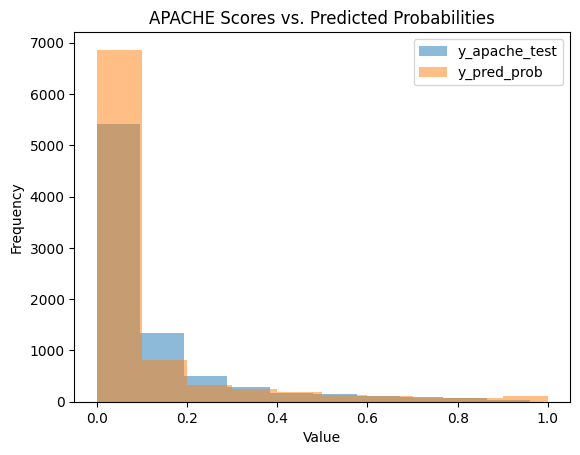

Mean Squared Error: 0.020767844454531875
Testing Accuracy: 0.9146054840514829
Testing F1 Score: 0.4015686274509804
Confusion Matrix:
 [[7916  263]
 [ 500  256]]
Equalized Odds accross ethnic groups:  0.18476190476190477
Equalized Odds accross gender groups:  0.4707146695325094
Demographic Parity accross ethnic groups:  0.04166451856816346
Demographic Parity accross gender groups:  0.4421607105969841


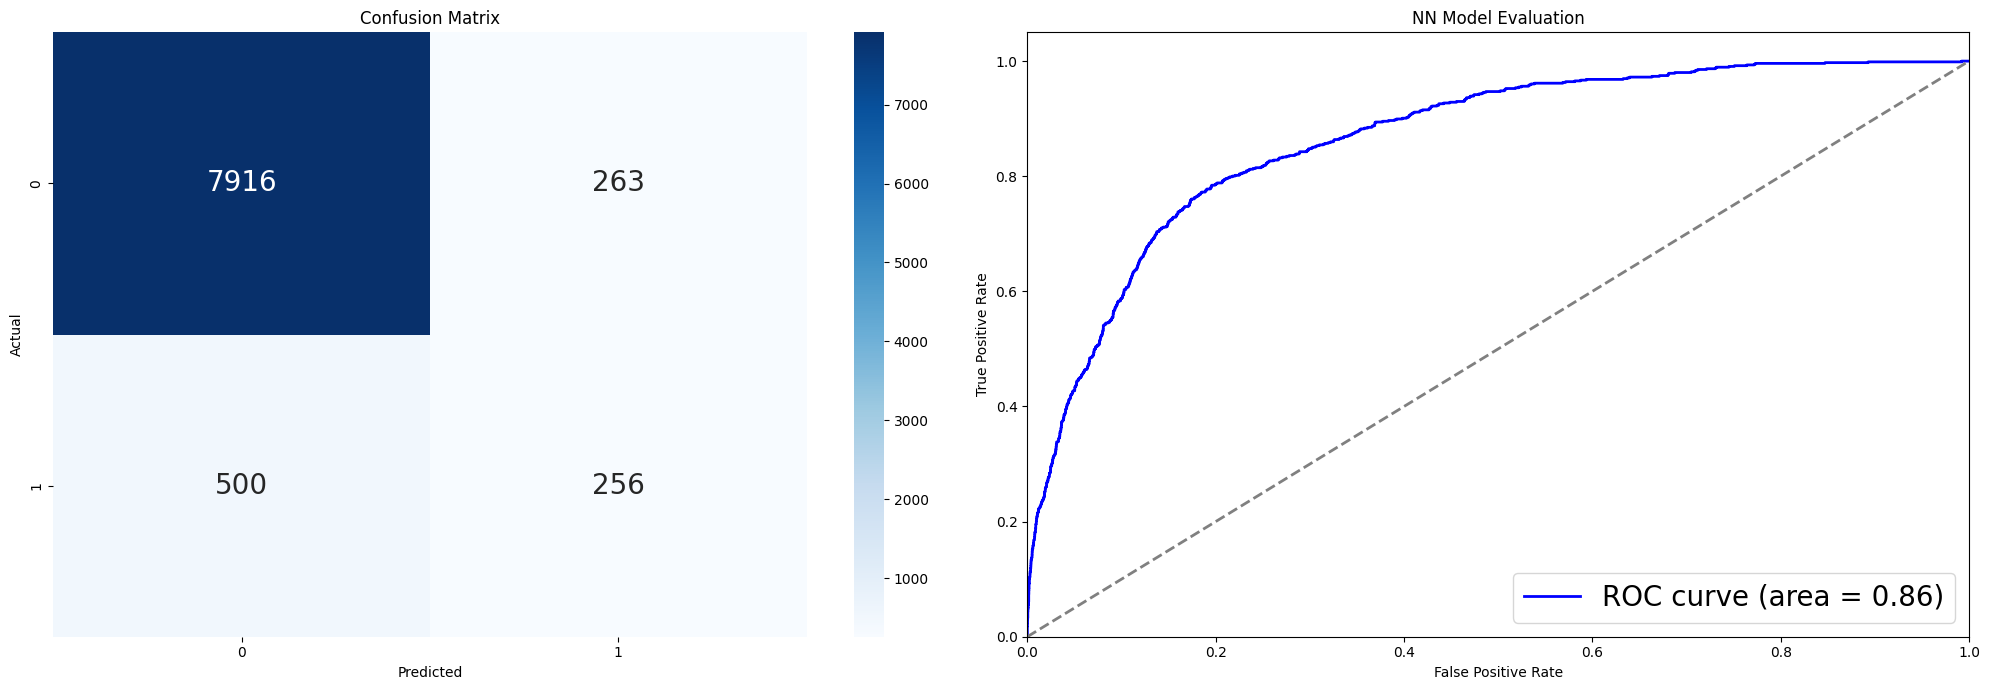

In [18]:
from classifier.nn_classifier import NeuralNetworkClassifier

best_nn_model = NeuralNetworkClassifier(input_dim=X_train_reduced.shape[1])
best_nn_model = torch.load("models/best_nn_model_oversampled.pth")
best_nn_model.eval()  # Set to evaluation mode

# positive class probability
y_pred_prob = best_nn_model.predict_proba(X_test_reduced.values)[:, 1]

num_bins = 10

# Plot histograms for the APACHE scores and the model's predicted probabilities.
plt.hist(pd.Series(y_apache_test), bins=num_bins, alpha=0.5, label='y_apache_test')
plt.hist(pd.Series(y_pred_prob), bins=num_bins, alpha=0.5, label='y_pred_prob')

plt.title("APACHE Scores vs. Predicted Probabilities")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("apache_vs_pred_prob.png")
plt.show()

# Create a boolean mask for valid (non-NaN) entries in y_apache_test
mask = ~np.isnan(y_apache_test)

# Filter both the ground truth and the predicted probabilities
y_apache_valid = y_apache_test[mask]
y_pred_prob_valid = y_pred_prob[mask]
mse = mean_squared_error(y_apache_valid, y_pred_prob_valid)
print("Mean Squared Error:", mse)

y_pred_test = best_nn_model.predict(X_test_reduced.values)  
accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred_test)
print("Testing F1 Score:", f1)

conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix)

print("Equalized Odds accross ethnic groups: ", -custom_eo_scorer(best_nn_model, X_test_reduced, y_test, sensitive_prefix="cat__ethnicity_"))
print("Equalized Odds accross gender groups: ", -custom_eo_scorer(best_nn_model, X_test_reduced, y_test, sensitive_prefix="cat__gender"))
print("Demographic Parity accross ethnic groups: ", -custom_dp_scorer(best_nn_model, X_test_reduced, y_test, sensitive_prefix="cat__ethnicity_"))
print("Demographic Parity accross gender groups: ", -custom_dp_scorer(best_nn_model, X_test_reduced, y_test, sensitive_prefix="cat__gender"))

if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
    y_pred_prob = y_pred_prob[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot confusion matrix and ROC curve in the same row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax1, annot_kws={'size': 20})
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix')

# plot ROC curve
ax2.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc="lower right", fontsize=20)

plt.title("NN Model Evaluation")
plt.tight_layout()
plt.show()

## Regression Model

In [19]:
import joblib
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# parameter grid
param_grid_reg = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],
    'class_weight': [{0: 1, 1: 2}, 'balanced', {0: 1, 1: 1}, {0: 1, 1: 1.5}]
}

# Initialize the logistic regression model
reg_estimator = LogisticRegression(random_state=random_state)

# Define a cross-validation strategy (using stratified k-fold for classification)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_reg = GridSearchCV(
    reg_estimator,
    param_grid_reg,
    cv=cv_strategy,
    scoring=scoring,
    refit='composite',  # choose composite for selecting the best model
    verbose=2
)

grid_search_reg.fit(X_train_reduced.values, y_train.values)

# Print the best parameters and best score
print("Best parameters found: ", grid_search_reg.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search_reg.best_score_))

results_reg = grid_search_reg.cv_results_
best_index_reg = grid_search_reg.best_index_

# Extract individual scores for the best model
best_accuracy_reg = results_reg['mean_test_accuracy'][best_index_reg]
best_eo_eth_reg = results_reg['mean_test_eo_ethnicity'][best_index_reg]
best_eo_gen_reg = results_reg['mean_test_eo_gender'][best_index_reg]
best_dp_eth_reg = results_reg['mean_test_dp_ethnicity'][best_index_reg]
best_dp_gen_reg = results_reg['mean_test_dp_gender'][best_index_reg]
best_composite_reg = results_reg['mean_test_composite'][best_index_reg]

print("Best composite score:", best_composite_reg)
print("Best Accuracy:", best_accuracy_reg)
print("Best EO (Ethnicity):", -best_eo_eth_reg)
print("Best EO (Gender):", -best_eo_gen_reg)
print("Best DP (Ethnicity):", -best_dp_eth_reg)
print("Best DP (Gender):", -best_dp_gen_reg)

# Save the best model
joblib.dump(grid_search_reg.best_estimator_, "models/best_regression_model_not_oversampled.pkl")

Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  12.0s
[CV] END C=0.01, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  11.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  11.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  10.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  10.1s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   8.5s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=   8.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=saga; total time=  12.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=saga; total time=  11.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=saga; total time=  11.1s
[CV] END C=0.01, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  14.0s
[CV] END C=0.01, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  12.5s
[CV] END C=0.01, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  10.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  10.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=   9.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=   9.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  11.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  10.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=   9.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=   9.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  11.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  11.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  11.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=   9.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=   9.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=   9.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=  12.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=  11.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=  12.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=   9.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=  10.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=saga; total time=  10.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  11.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  11.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  12.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  10.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  11.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  10.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  11.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  11.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=   9.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=   9.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  10.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  11.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  14.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  14.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  10.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=   9.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  10.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=  11.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=  12.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=  11.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l2, solver=saga; total time=  10.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l2, solver=saga; total time=  10.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight=balanced, penalty=l2, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  12.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  13.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  13.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  10.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  11.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  10.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  12.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  12.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  13.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  11.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  11.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  12.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  12.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  13.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  11.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  10.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  10.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, penalty=l1, solver=saga; total time=  13.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, penalty=l1, solver=saga; total time=  12.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, penalty=l1, solver=saga; total time=  12.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=  10.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=  10.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=  11.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  13.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  13.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  13.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  11.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  10.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  10.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  13.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  13.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  13.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  11.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  11.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  13.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  13.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 2}, penalty=l1, solver=saga; total time=  12.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  11.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  11.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 2}, penalty=l2, solver=saga; total time=  11.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=  13.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=  13.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=  13.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=  10.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=  11.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=  11.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  13.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  13.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1}, penalty=l1, solver=saga; total time=  13.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  11.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  10.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1}, penalty=l2, solver=saga; total time=  11.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  12.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  12.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1.5}, penalty=l1, solver=saga; total time=  13.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  10.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  11.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, class_weight={0: 1, 1: 1.5}, penalty=l2, solver=saga; total time=  10.1s
Best parameters found:  {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation accuracy: 0.41
Best composite score: 0.4051912067477606
Best Accuracy: 0.8146293008939756
Best EO (Ethnicity): 0.18101971285332916
Best EO (Gender): 0.22486355429501023
Best DP (Ethnicity): 0.0859950793987595
Best DP (Gender): 0.28027183409467177


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


['models/best_regression_model_not_oversampled.pkl']

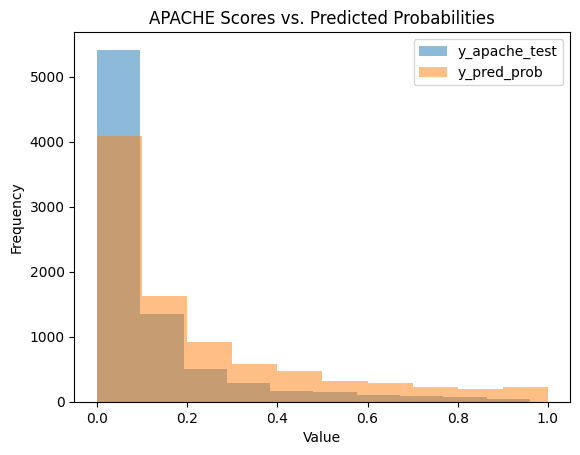

Mean Squared Error: 0.03547921148536225
Testing Accuracy: 0.8717403469501959
Testing F1 Score: 0.4281437125748503
Confusion Matrix:
 [[7360  819]
 [ 327  429]]
Equalized Odds accross ethnic groups:  0.29523809523809524
Equalized Odds accross gender groups:  0.581081081081081
Demographic Parity accross ethnic groups:  0.07312179349840826
Demographic Parity accross gender groups:  0.36490394546581284


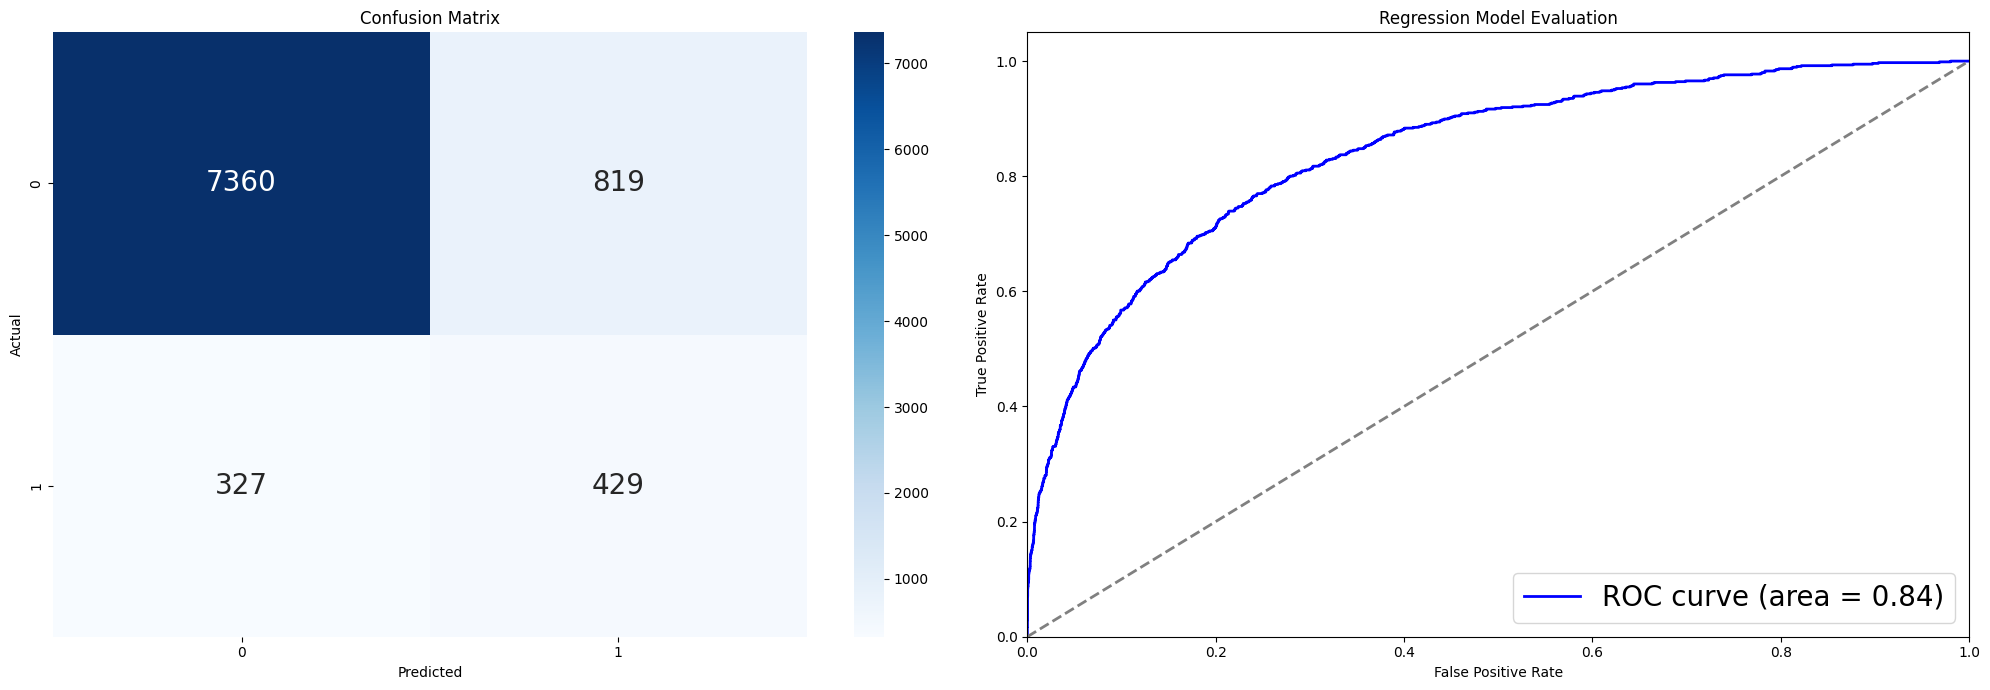

In [20]:
best_reg_model = joblib.load("models/best_regression_model_oversampled.pkl")

# positive class probability
y_pred_prob = best_reg_model.predict_proba(X_test_reduced.values)[:, 1]

num_bins = 10

# Plot histograms for the APACHE scores and the model's predicted probabilities.
plt.hist(pd.Series(y_apache_test), bins=num_bins, alpha=0.5, label='y_apache_test')
plt.hist(pd.Series(y_pred_prob), bins=num_bins, alpha=0.5, label='y_pred_prob')

plt.title("APACHE Scores vs. Predicted Probabilities")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("apache_vs_pred_prob.png")
plt.show()

# Create a boolean mask for valid (non-NaN) entries in y_apache_test
mask = ~np.isnan(y_apache_test)

# Filter both the ground truth and the predicted probabilities
y_apache_valid = y_apache_test[mask]
y_pred_prob_valid = y_pred_prob[mask]
mse = mean_squared_error(y_apache_valid, y_pred_prob_valid)
print("Mean Squared Error:", mse)

y_pred_test = best_reg_model.predict(X_test_reduced.values)
accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred_test)
print("Testing F1 Score:", f1)

conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix)

print("Equalized Odds accross ethnic groups: ", -custom_eo_scorer(best_reg_model, X_test_reduced, y_test, sensitive_prefix="cat__ethnicity_"))
print("Equalized Odds accross gender groups: ", -custom_eo_scorer(best_reg_model, X_test_reduced, y_test, sensitive_prefix="cat__gender"))
print("Demographic Parity accross ethnic groups: ", -custom_dp_scorer(best_reg_model, X_test_reduced, y_test, sensitive_prefix="cat__ethnicity_"))
print("Demographic Parity accross gender groups: ", -custom_dp_scorer(best_reg_model, X_test_reduced, y_test, sensitive_prefix="cat__gender"))

if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
    y_pred_prob = y_pred_prob[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot confusion matrix and ROC curve in the same row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax1, annot_kws={'size': 20})
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix')

# plot ROC curve
ax2.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc="lower right", fontsize=20)

plt.title("Regression Model Evaluation")
plt.tight_layout()
plt.show()

# Evaluation with APACHE IV Scores


Accuracy: 0.87
Precision: 0.34
Recall: 0.57
F1 Score: 0.43
Confusion Matrix:
 [[7360  819]
 [ 327  429]]
Optimal Threshold: 0.2651623469146016


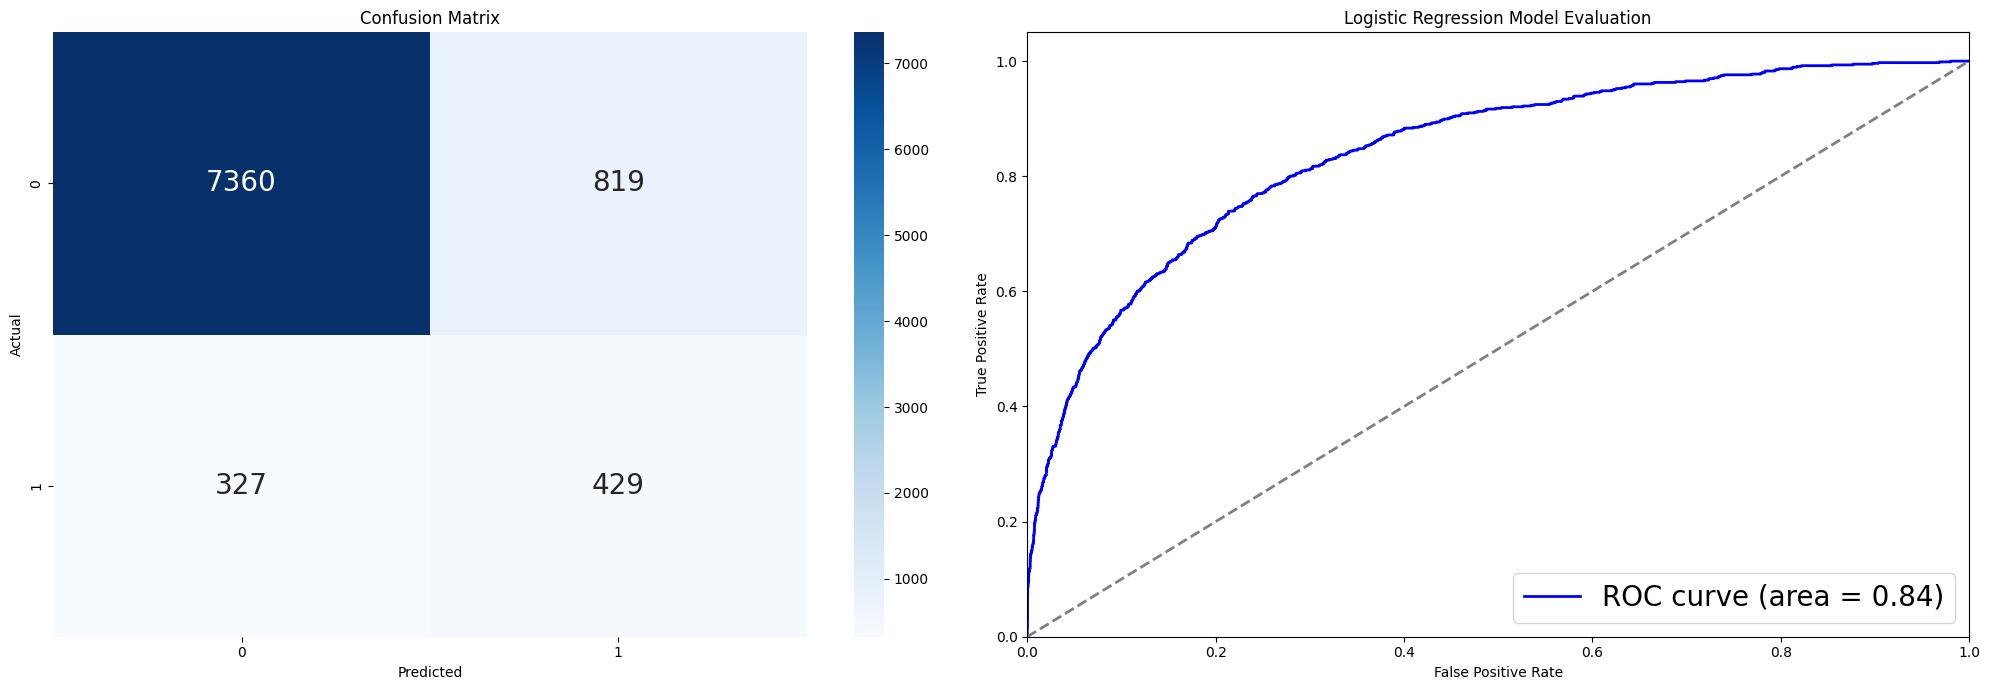

In [21]:
# predict on the test set
y_pred = best_reg_model.predict(X_test_reduced.values)
y_pred_prob = best_reg_model.predict_proba(X_test_reduced.values)[:, 1]

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: %.2f" % accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)
print("F1 Score: %.2f" % f1)
print("Confusion Matrix:\n", conf_matrix)

# compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic
youden_j = tpr - fpr

# Find the threshold that maximizes Youden's J statistic
optimal_threshold = thresholds[np.argmax(youden_j)]
print(f"Optimal Threshold: {optimal_threshold}")

# plot confusion matrix and ROC curve in the same row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax1, annot_kws={'size': 20})
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix')

# plot ROC curve
ax2.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc="lower right", fontsize=20)

plt.title("Logistic Regression Model Evaluation")
plt.tight_layout()
plt.show()

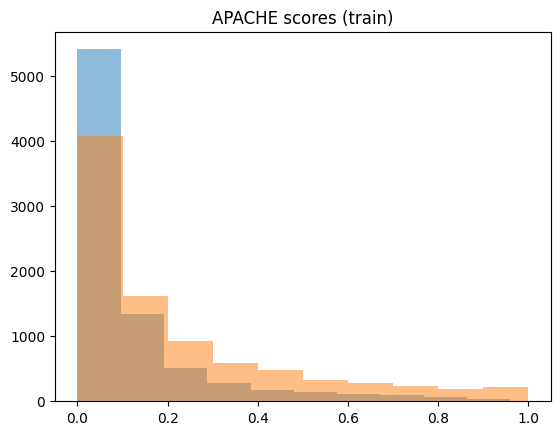

In [22]:
num_bins = 10

# histogram
plt.hist(pd.Series(y_apache_test), bins=num_bins, alpha=0.5, label='y_apache_test')
plt.hist(pd.Series(y_pred_prob), bins=num_bins, alpha=0.5, label='y_pred_prob')


plt.title("APACHE scores (train)")
plt.show()



# XGBoost model


In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pickle

# Hyperparameter grid for the model
param_grid_xgb = {
    'n_estimators': [100, 200],  	# Number of boosting rounds
    'learning_rate': [0.01, 0.1],  	# Step size shrinkage
    'max_depth': [3, 5],  		    # Depth of trees
    'subsample': [1.0],  		    # Fraction of training instances per boosting round
    'colsample_bytree': [1.0], 	 	# Fraction of features per boosting round
    'gamma': [0, 0.1],  		    # Minimum loss reduction to make further partition
    'scale_pos_weight': [1, 2]  	# Handling class imbalance
}

# Initialize Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Defining the type pf strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search
grid_search_xgb = GridSearchCV(
    xgb_model,
    param_grid_xgb,
    cv=cv_strategy,
    scoring=scoring,
    refit='composite',  # Choose composite score for best model selection
    verbose=2
)

# Grid search
grid_search_xgb.fit(X_train_reduced.values, y_train.values)

# Computing best hyperparameters
# Print the best parameters and best score
print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search_xgb.best_score_))

# CV results dictionary
results_xgb = grid_search_xgb.cv_results_
best_index_xgb = grid_search_xgb.best_index_

# Extract individual scores for the best model
best_accuracy_xgb = results_xgb['mean_test_accuracy'][best_index_xgb]
best_eo_eth_xgb = results_xgb['mean_test_eo_ethnicity'][best_index_xgb]
best_eo_gen_xgb = results_xgb['mean_test_eo_gender'][best_index_xgb]
best_dp_eth_xgb = results_xgb['mean_test_dp_ethnicity'][best_index_xgb]
best_dp_gen_xgb = results_xgb['mean_test_dp_gender'][best_index_xgb]
best_composite_xgb = results_xgb['mean_test_composite'][best_index_xgb]

print("Best composite score:", best_composite_xgb)
print("Best Accuracy:", best_accuracy_xgb)
print("Best EO (Ethnicity):", -best_eo_eth_xgb)
print("Best EO (Gender):", -best_eo_gen_xgb)
print("Best DP (Ethnicity):", -best_dp_eth_xgb)
print("Best DP (Gender):", -best_dp_gen_xgb)

# Best model
best_xgb_model = grid_search_xgb.best_estimator_

# Save the GridSearchCV object
with open('models/best_xgb_model_not_oversampled.pkl', 'wb') as model_file:
    pickle.dump(best_xgb_model, model_file)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:23:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   2.9s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.5s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.1s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.0s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.8s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.7s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.6s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=1, subsample=1.0; total time=   3.3s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, scale_pos_weight=2, subsample=1.0; total time=   3.2s


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 1.0}
Best cross-validation accuracy: 0.36
Best composite score: 0.36367230912474496
Best Accuracy: 0.9221104551014306
Best EO (Ethnicity): 0.13461848360325515
Best EO (Gender): 0.12471565242637477
Best DP (Ethnicity): 0.016426523597801085
Best DP (Gender): 0.012820054651165418


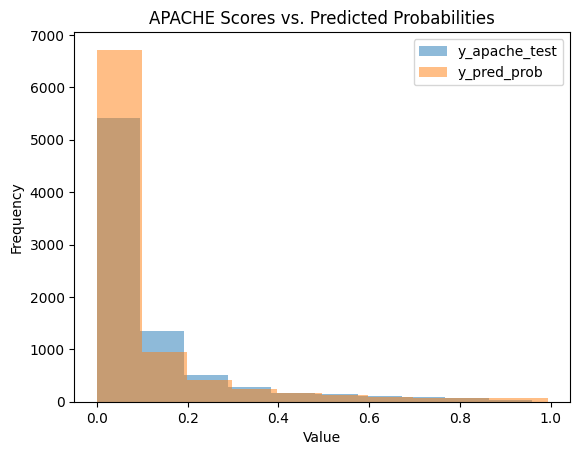

Mean Squared Error: 0.01164327687758793
Testing Accuracy: 0.927364297705652
Testing F1 Score: 0.4495335029686175
Confusion Matrix:
 [[8021  158]
 [ 491  265]]
Equalized Odds accross ethnic groups:  0.23333333333333336
Equalized Odds accross gender groups:  0.3675675675675676
Demographic Parity accross ethnic groups:  0.03450655624568667
Demographic Parity accross gender groups:  0.051319648093841645


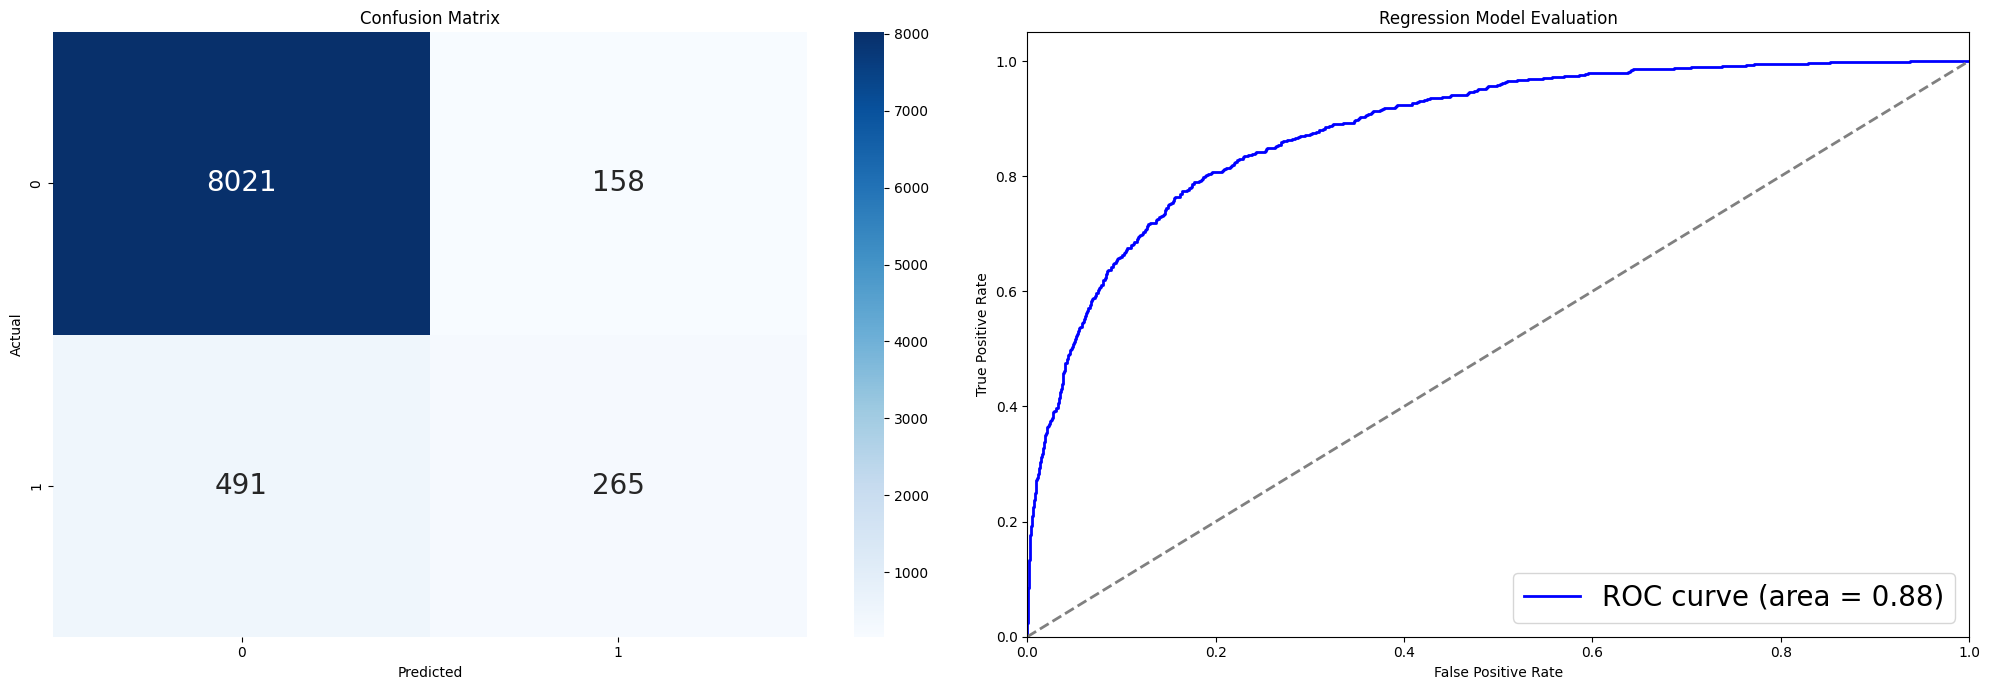

In [24]:
# TODO: Load model and test
with open('models/best_xgb_model_oversampled.pkl', 'rb') as model_file:
    best_xgb_model = pickle.load(model_file)

y_pred_prob_xgb = best_xgb_model.predict_proba(X_test_reduced.values)[:, 1]
# y_pred_prob = y_pred_prob[:, 1]  # Select the probability for the positive class

num_bins = 10

# Plot histograms for the APACHE scores and the model's predicted probabilities.
plt.hist(pd.Series(y_apache_test), bins=num_bins, alpha=0.5, label='y_apache_test')
plt.hist(pd.Series(y_pred_prob_xgb), bins=num_bins, alpha=0.5, label='y_pred_prob')

plt.title("APACHE Scores vs. Predicted Probabilities")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("apache_vs_pred_prob.png")
plt.show()

# Create a boolean mask for valid (non-NaN) entries in y_apache_test
mask = ~np.isnan(y_apache_test)

# Filter both the ground truth and the predicted probabilities
y_apache_valid = y_apache_test[mask]
y_pred_prob_valid = y_pred_prob_xgb[mask]
mse = mean_squared_error(y_apache_valid, y_pred_prob_valid)
print("Mean Squared Error:", mse)

y_pred_test = best_xgb_model.predict(X_test_reduced.values)
accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", accuracy)

f1 = f1_score(y_test, y_pred_test)
print("Testing F1 Score:", f1)

conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix)

print("Equalized Odds accross ethnic groups: ", -custom_eo_scorer(best_xgb_model, X_test_reduced, y_test, sensitive_prefix="cat__ethnicity_"))
print("Equalized Odds accross gender groups: ", -custom_eo_scorer(best_xgb_model, X_test_reduced, y_test, sensitive_prefix="cat__gender"))
print("Demographic Parity accross ethnic groups: ", -custom_dp_scorer(best_xgb_model, X_test_reduced, y_test, sensitive_prefix="cat__ethnicity_"))
print("Demographic Parity accross gender groups: ", -custom_dp_scorer(best_xgb_model, X_test_reduced, y_test, sensitive_prefix="cat__gender"))

if y_pred_prob_valid.ndim > 1 and y_pred_prob_valid.shape[1] > 1:
    y_pred_prob_valid = y_pred_prob_valid[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

# plot confusion matrix and ROC curve in the same row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax1, annot_kws={'size': 20})
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix')

# plot ROC curve
ax2.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc="lower right", fontsize=20)

plt.title("Regression Model Evaluation")
plt.tight_layout()
plt.show()


# XGBoost Threshold optimization

We define some utility functions

In [25]:
from fairlearn.metrics import (
    false_positive_rate,
    false_negative_rate,
    true_positive_rate,
    MetricFrame,
    equalized_odds_difference,
    demographic_parity_difference
)

# Function to score and display metrics
def display_metrics(y_true, y_pred, sensitive_features, dataset_name=""):
    metrics = {
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate,
        "tpr": true_positive_rate
    }
    
    mf = MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    
    print(f"\n--- {dataset_name} Metrics by Group ---")
    display(mf.by_group)
    
    # Overall metrics
    eo_diff = equalized_odds_difference(
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    dp_diff = demographic_parity_difference(
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    
    print(f"Equalized odds difference: {eo_diff:.4f}")
    print(f"Demographic parity difference: {dp_diff:.4f}")
    print(f"Overall accuracy: {acc:.4f}")
    
    return eo_diff, dp_diff, acc, mf


# Function to find optimal thresholds to equalize a specific metric
def find_optimal_thresholds(y_true, y_score, sensitive_features, metric_name="fpr"):
    groups = sensitive_features.unique()
    
    # Calculate the metric for each group at different thresholds
    group_metrics = {}
    thresholds_range = np.arange(0.01, 1.0, 0.01)
    
    for group in groups:
        group_indices = sensitive_features[sensitive_features == group].index
        # Proceed only if there is sufficient variation in y_true for the group
        if len(group_indices) > 0 and y_true[group_indices].nunique() > 1:
            group_metrics[group] = {}
            
            for threshold in thresholds_range:
                y_pred = y_score[group_indices] >= threshold
                
                if metric_name == "fpr" or metric_name == "both":
                    fpr = false_positive_rate(y_true[group_indices], y_pred)
                    # If we're using only fpr, store the value directly;
                    # if "both", store in a dict.
                    group_metrics[group][threshold] = fpr if metric_name == "fpr" else {"fpr": fpr}
                
                if metric_name == "tpr" or metric_name == "both":
                    tpr = true_positive_rate(y_true[group_indices], y_pred)
                    if metric_name == "tpr":
                        group_metrics[group][threshold] = tpr
                    elif metric_name == "both":
                        group_metrics[group][threshold]["tpr"] = tpr

                if metric_name == "fnr":
                    fnr = false_negative_rate(y_true[group_indices], y_pred)
                    group_metrics[group][threshold] = fnr
    
    # Find a target metric value that all groups can achieve
    if metric_name == "fpr":
        # For FPR, we want the highest (least favorable) best-case FPR among all groups.
        achievable_values = []
        for group, metrics in group_metrics.items():
            if metrics:  # Skip empty groups
                achievable_values.append(min(metrics.values()))
        if not achievable_values:
            return {}
        target_value = max(achievable_values)
        
    elif metric_name == "tpr":
        # For TPR, we want the lowest (least favorable) best-case TPR across groups.
        achievable_values = []
        for group, metrics in group_metrics.items():
            if metrics:
                achievable_values.append(max(metrics.values()))
        if not achievable_values:
            return {}
        target_value = min(achievable_values)
    
    elif metric_name == "fnr":
        # For FNR, lower is better so we follow the same logic as FPR:
        # take the minimum achievable FNR for each group and then the highest among those.
        achievable_values = []
        for group, metrics in group_metrics.items():
            if metrics:
                achievable_values.append(min(metrics.values()))
        if not achievable_values:
            return {}
        target_value = max(achievable_values)
    
    # Find thresholds that achieve the target value for each group
    optimal_thresholds = {}
    
    for group in groups:
        if group not in group_metrics or not group_metrics[group]:
            optimal_thresholds[group] = 0.5  # Default if no data
            continue
            
        # Find threshold that gives closest metric value to target_value
        closest_threshold = min(
            group_metrics[group].keys(),
            key=lambda t: abs(group_metrics[group][t] - target_value)
        )
        optimal_thresholds[group] = closest_threshold
    
    return optimal_thresholds

## Metrics on sensitive features

AUC scores for each ethnic group on training data:
Caucasian: 0.9897 (n=80227)
African American: 0.9794 (n=8599)
Other/Unknown: 0.9519 (n=3444)
Hispanic: 0.9502 (n=3077)
Asian: 0.9475 (n=882)
missing: 0.9675 (n=1093)
Native American: 0.9813 (n=641)

AUC scores for each ethnic group on test data:
Caucasian: 0.8793 (n=6901)
African American: 0.9139 (n=978)
Other/Unknown: 0.9005 (n=398)
Hispanic: 0.8911 (n=378)
Asian: 0.8585 (n=92)
missing: 0.8899 (n=119)
Native American: 0.8915 (n=69)

=== BASELINE METRICS (threshold=0.5) ===

--- Training Metrics by Group ---


,accuracy,fpr,fnr,tpr
sensitive_feature_0,,,,
cat__ethnicity_African American,0.957437,0.006149,0.183154,0.816846
cat__ethnicity_Asian,0.944444,0.008685,0.552632,0.447368
cat__ethnicity_Caucasian,0.959989,0.010551,0.089354,0.910646
cat__ethnicity_Hispanic,0.935977,0.007775,0.468085,0.531915
cat__ethnicity_Native American,0.967239,0.005172,0.295082,0.704918
cat__ethnicity_Other/Unknown,0.951510,0.006347,0.501706,0.498294
cat__ethnicity_missing,0.950595,0.004965,0.569767,0.430233


Equalized odds difference: 0.4804
Demographic parity difference: 0.3086
Overall accuracy: 0.9585

--- Test Metrics by Group ---


,accuracy,fpr,fnr,tpr
sensitive_feature_0,,,,
cat__ethnicity_African American,0.932515,0.013289,0.720000,0.280000
cat__ethnicity_Asian,0.923913,0.034884,0.666667,0.333333
cat__ethnicity_Caucasian,0.926822,0.019978,0.638047,0.361953
cat__ethnicity_Hispanic,0.917989,0.029155,0.600000,0.400000
cat__ethnicity_Native American,0.913043,0.015873,0.833333,0.166667
cat__ethnicity_Other/Unknown,0.937186,0.010899,0.677419,0.322581
cat__ethnicity_missing,0.924370,0.018182,0.777778,0.222222


Equalized odds difference: 0.2333
Demographic parity difference: 0.0345
Overall accuracy: 0.9274

=== FINDING OPTIMAL THRESHOLDS TO EQUALIZE FPR ===

Optimal thresholds for equalizing FPR:
Caucasian: 0.8800
African American: 0.8500
Other/Unknown: 0.8000
Hispanic: 0.8400
Asian: 0.7700
missing: 0.7400
Native American: 0.7300

=== METRICS WITH FPR-OPTIMAL THRESHOLDS ===

--- Training Metrics by Group ---


,accuracy,fpr,fnr,tpr
sensitive_feature_0,,,,
cat__ethnicity_African American,0.932783,0.0,0.326738,0.673262
cat__ethnicity_Asian,0.931973,0.0,0.789474,0.210526
cat__ethnicity_Caucasian,0.926795,0.0,0.195812,0.804188
cat__ethnicity_Hispanic,0.913552,0.0,0.707447,0.292553
cat__ethnicity_Native American,0.942278,0.0,0.606557,0.393443
cat__ethnicity_Other/Unknown,0.933217,0.0,0.784983,0.215017
cat__ethnicity_missing,0.942360,0.0,0.732558,0.267442


Equalized odds difference: 0.5937
Demographic parity difference: 0.2825
Overall accuracy: 0.9275

--- Test Metrics by Group ---


,accuracy,fpr,fnr,tpr
sensitive_feature_0,,,,
cat__ethnicity_African American,0.931493,0.001107,0.880000,0.120000
cat__ethnicity_Asian,0.934783,0.011628,0.833333,0.166667
cat__ethnicity_Caucasian,0.921026,0.001268,0.904040,0.095960
cat__ethnicity_Hispanic,0.915344,0.005831,0.857143,0.142857
cat__ethnicity_Native American,0.913043,0.000000,1.000000,0.000000
cat__ethnicity_Other/Unknown,0.929648,0.002725,0.870968,0.129032
cat__ethnicity_missing,0.941176,0.000000,0.777778,0.222222


Equalized odds difference: 0.2222
Demographic parity difference: 0.0217
Overall accuracy: 0.9227

=== FINDING OPTIMAL THRESHOLDS TO EQUALIZE FNR ===

Optimal thresholds for equalizing FNR:
Caucasian: 0.0400
African American: 0.0100
Other/Unknown: 0.0200
Hispanic: 0.0100
Asian: 0.0100
missing: 0.0100
Native American: 0.0100

=== METRICS WITH FNR-OPTIMAL THRESHOLDS ===

--- Training Metrics by Group ---


,accuracy,fpr,fnr,tpr
sensitive_feature_0,,,,
cat__ethnicity_African American,0.487266,0.644802,0.002826,0.997174
cat__ethnicity_Asian,0.328798,0.734491,0.000000,1.000000
cat__ethnicity_Caucasian,0.746644,0.401839,0.004668,0.995332
cat__ethnicity_Hispanic,0.397140,0.686042,0.005319,0.994681
cat__ethnicity_Native American,0.407176,0.655172,0.000000,1.000000
cat__ethnicity_Other/Unknown,0.601916,0.434465,0.006826,0.993174
cat__ethnicity_missing,0.400732,0.650447,0.000000,1.000000


Equalized odds difference: 0.3327
Demographic parity difference: 0.2754
Overall accuracy: 0.6980

--- Test Metrics by Group ---


,accuracy,fpr,fnr,tpr
sensitive_feature_0,,,,
cat__ethnicity_African American,0.415133,0.632337,0.013333,0.986667
cat__ethnicity_Asian,0.304348,0.744186,0.000000,1.000000
cat__ethnicity_Caucasian,0.610781,0.418741,0.075758,0.924242
cat__ethnicity_Hispanic,0.380952,0.682216,0.000000,1.000000
cat__ethnicity_Native American,0.362319,0.698413,0.000000,1.000000
cat__ethnicity_Other/Unknown,0.577889,0.455041,0.032258,0.967742
cat__ethnicity_missing,0.344538,0.709091,0.000000,1.000000


Equalized odds difference: 0.3254
Demographic parity difference: 0.2986
Overall accuracy: 0.5696

=== SUMMARY OF ALL APPROACHES ===


,Method,Train EO Diff,Test EO Diff,Train DP Diff,Test DP Diff,Train Accuracy,Test Accuracy
0,Baseline (0.5),0.480413,0.233333,0.308626,0.034507,0.958515,0.927364
1,FPR-Equalized,0.593661,0.222222,0.282506,0.021739,0.927452,0.922664
2,FNR-Equalized,0.332652,0.325445,0.275372,0.298618,0.697968,0.569558


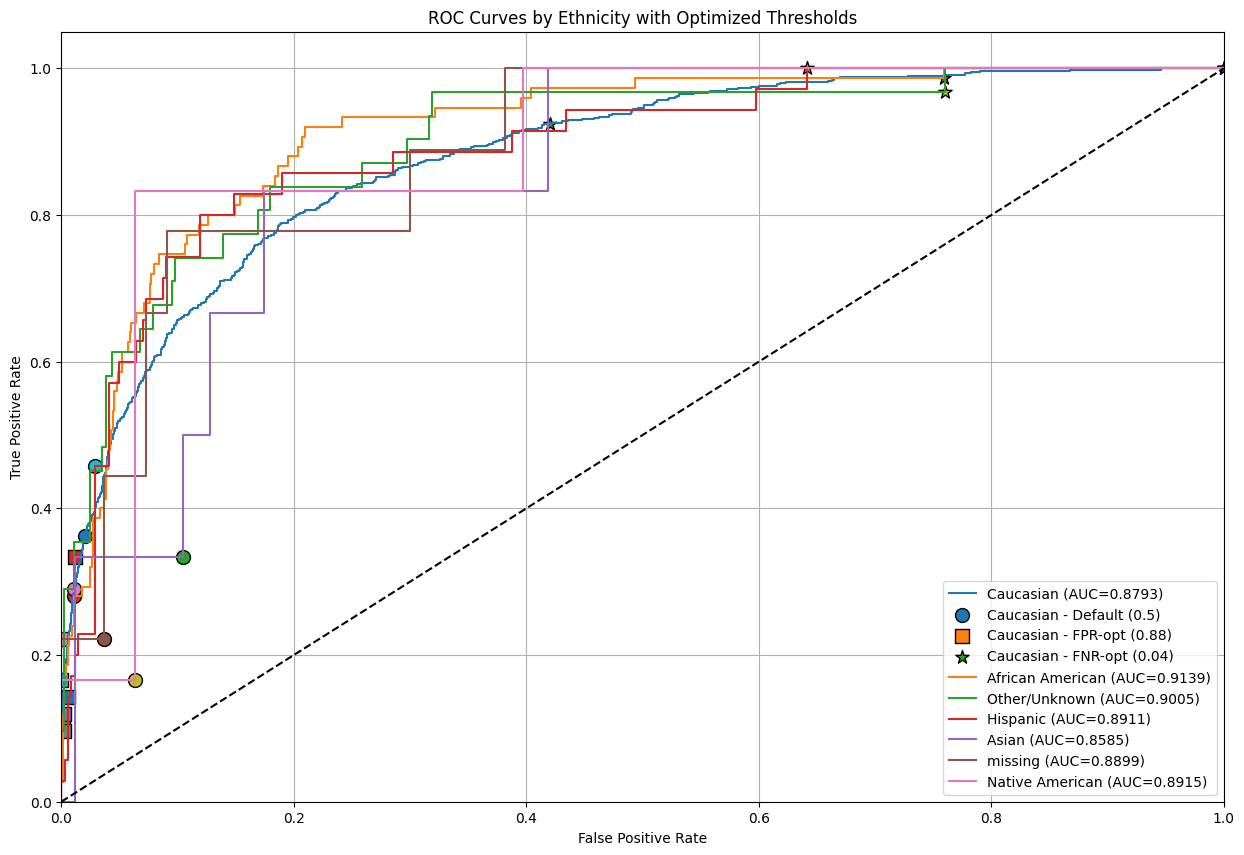


=== OPTIMAL THRESHOLDS SUMMARY ===


,Group,Default,FPR_Optimal,FNR_Optimal
0,Caucasian,0.5,0.88,0.04
1,African American,0.5,0.85,0.01
2,Other/Unknown,0.5,0.80,0.02
3,Hispanic,0.5,0.84,0.01
4,Asian,0.5,0.77,0.01
5,missing,0.5,0.74,0.01
6,Native American,0.5,0.73,0.01


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, roc_auc_score

# load model
with open('models/best_xgb_model_oversampled.pkl', 'rb') as model_file:
    best_xgb_model = pickle.load(model_file)

# sensitive features for all ethnic groups
sensitive_features_train_eth = X_train_resampled.filter(like='cat__ethnicity_').idxmax(axis=1)
sensitive_features_test_eth = X_test_reduced.filter(like='cat__ethnicity_').idxmax(axis=1)

y_train_score_xgb = pd.Series(best_xgb_model.predict_proba(X_train_resampled)[:, 1], index=X_train_resampled.index)
y_test_score_xgb = pd.Series(best_xgb_model.predict_proba(X_test_reduced)[:, 1], index=X_test_reduced.index)

# align indices
y_train_resampled_aligned = y_train_resampled.reindex(sensitive_features_train_eth.index)
y_test = y_test.reset_index(drop=True)
y_test_aligned = y_test.reindex(sensitive_features_test_eth.index)

# Get unique ethnic groups
ethnic_groups = sensitive_features_train_eth.unique()

# Calculate AUC for each group to verify our data
print("AUC scores for each ethnic group on training data:")
for group in ethnic_groups:
    group_indices = sensitive_features_train_eth[sensitive_features_train_eth == group].index
    if len(group_indices) > 0 and y_train_resampled_aligned[group_indices].nunique() > 1:
        group_auc = roc_auc_score(
            y_train_resampled_aligned[group_indices], 
            y_train_score_xgb[group_indices]
        )
        print(f"{group.replace('cat__ethnicity_', '')}: {group_auc:.4f} (n={len(group_indices)})")
    else:
        print(f"{group.replace('cat__ethnicity_', '')}: Not enough data for AUC calculation")

print("\nAUC scores for each ethnic group on test data:")
for group in ethnic_groups:
    group_indices = sensitive_features_test_eth[sensitive_features_test_eth == group].index
    if len(group_indices) > 0 and y_test_aligned[group_indices].nunique() > 1:
        group_auc = roc_auc_score(
            y_test_aligned[group_indices], 
            y_test_score_xgb[group_indices]
        )
        print(f"{group.replace('cat__ethnicity_', '')}: {group_auc:.4f} (n={len(group_indices)})")
    else:
        print(f"{group.replace('cat__ethnicity_', '')}: Not enough data for AUC calculation")

# Calculate baseline metrics with default threshold (0.5)
y_train_pred_baseline = y_train_score_xgb >= 0.5
y_test_pred_baseline = y_test_score_xgb >= 0.5

# Display baseline metrics
print("\n=== BASELINE METRICS (threshold=0.5) ===")
train_eo_diff, train_dp_diff, train_acc, _ = display_metrics(
    y_train_resampled_aligned, y_train_pred_baseline, sensitive_features_train_eth, "Training"
)
test_eo_diff, test_dp_diff, test_acc, _ = display_metrics(
    y_test_aligned, y_test_pred_baseline, sensitive_features_test_eth, "Test"
)

# Try equalizing False Positive Rate (FPR)
print("\n=== FINDING OPTIMAL THRESHOLDS TO EQUALIZE FPR ===")
fpr_thresholds = find_optimal_thresholds(
    y_train_resampled_aligned, y_train_score_xgb, sensitive_features_train_eth, "fpr"
)

# Print the optimal thresholds
print("\nOptimal thresholds for equalizing FPR:")
for group, threshold in fpr_thresholds.items():
    print(f"{group.replace('cat__ethnicity_', '')}: {threshold:.4f}")

# Apply the FPR-optimal thresholds
y_train_pred_fpr_opt = pd.Series(False, index=y_train_resampled_aligned.index)
y_test_pred_fpr_opt = pd.Series(False, index=y_test_aligned.index)

for group, threshold in fpr_thresholds.items():
    # Training data
    group_indices_train = sensitive_features_train_eth[sensitive_features_train_eth == group].index
    y_train_pred_fpr_opt[group_indices_train] = y_train_score_xgb[group_indices_train] >= threshold
    
    # Test data
    group_indices_test = sensitive_features_test_eth[sensitive_features_test_eth == group].index
    y_test_pred_fpr_opt[group_indices_test] = y_test_score_xgb[group_indices_test] >= threshold

# Display metrics with FPR-optimal thresholds
print("\n=== METRICS WITH FPR-OPTIMAL THRESHOLDS ===")
train_eo_diff_fpr, train_dp_diff_fpr, train_acc_fpr, _ = display_metrics(
    y_train_resampled_aligned, y_train_pred_fpr_opt, sensitive_features_train_eth, "Training"
)
test_eo_diff_fpr, test_dp_diff_fpr, test_acc_fpr, _ = display_metrics(
    y_test_aligned, y_test_pred_fpr_opt, sensitive_features_test_eth, "Test"
)

# Try equalizing both (Equalized Odds)
print("\n=== FINDING OPTIMAL THRESHOLDS TO EQUALIZE FNR ===")
fnr_thresholds = find_optimal_thresholds(
    y_train_resampled_aligned, y_train_score_xgb, sensitive_features_train_eth, "fnr"
)

# Print the optimal thresholds
print("\nOptimal thresholds for equalizing FNR:")
for group, threshold in fnr_thresholds.items():
    print(f"{group.replace('cat__ethnicity_', '')}: {threshold:.4f}")

# Apply the EO-optimal thresholds
y_train_pred_eo_opt = pd.Series(False, index=y_train_resampled_aligned.index)
y_test_pred_eo_opt = pd.Series(False, index=y_test_aligned.index)

for group, threshold in fnr_thresholds.items():
    # Training data
    group_indices_train = sensitive_features_train_eth[sensitive_features_train_eth == group].index
    y_train_pred_eo_opt[group_indices_train] = y_train_score_xgb[group_indices_train] >= threshold
    
    # Test data
    group_indices_test = sensitive_features_test_eth[sensitive_features_test_eth == group].index
    y_test_pred_eo_opt[group_indices_test] = y_test_score_xgb[group_indices_test] >= threshold

# Display metrics with EO-optimal thresholds
print("\n=== METRICS WITH FNR-OPTIMAL THRESHOLDS ===")
train_eo_diff_fnr, train_dp_diff_fnr, train_acc_fnr, _ = display_metrics(
    y_train_resampled_aligned, y_train_pred_eo_opt, sensitive_features_train_eth, "Training"
)
test_eo_diff_fnr, test_dp_diff_fnr, test_acc_fnr, _ = display_metrics(
    y_test_aligned, y_test_pred_eo_opt, sensitive_features_test_eth, "Test"
)

# Compare all approaches
results = pd.DataFrame({
    'Method': ['Baseline (0.5)', 'FPR-Equalized', 'FNR-Equalized'], 
    'Train EO Diff': [train_eo_diff, train_eo_diff_fpr, train_eo_diff_fnr],
    'Test EO Diff': [test_eo_diff, test_eo_diff_fpr, test_eo_diff_fnr],
    'Train DP Diff': [train_dp_diff, train_dp_diff_fpr, train_dp_diff_fnr],
    'Test DP Diff': [test_dp_diff, test_dp_diff_fpr, test_dp_diff_fnr],
    'Train Accuracy': [train_acc, train_acc_fpr, train_acc_fnr],
    'Test Accuracy': [test_acc, test_acc_fpr, test_acc_fnr]
})

print("\n=== SUMMARY OF ALL APPROACHES ===")
display(results)

# Visualize the results
plt.figure(figsize=(15, 10))

# Plot ROC curves for different ethnic groups with their optimal thresholds
for group in ethnic_groups:
    group_indices_test = sensitive_features_test_eth[sensitive_features_test_eth == group].index
    
    if len(group_indices_test) > 0 and y_test_aligned[group_indices_test].nunique() > 1:
        fpr, tpr, thresholds = roc_curve(
            y_true=y_test_aligned[group_indices_test],
            y_score=y_test_score_xgb[group_indices_test]
        )
        
        group_auc = roc_auc_score(
            y_test_aligned[group_indices_test],
            y_test_score_xgb[group_indices_test]
        )
        
        plt.plot(
            fpr, tpr,
            label=f"{group.replace('cat__ethnicity_', '')} (AUC={group_auc:.4f})"
        )
        
        # Mark different thresholds
        # Default threshold (0.5)
        idx_default = np.argmin(np.abs(thresholds - 0.5)) if len(thresholds) > 0 else 0
        if idx_default < len(fpr):
            plt.scatter(
                fpr[idx_default], tpr[idx_default],
                marker='o', s=100, edgecolor='black',
                label=f"{group.replace('cat__ethnicity_', '')} - Default (0.5)" if group == ethnic_groups[0] else ""
            )
        
        # FPR-optimal threshold
        if group in fpr_thresholds:
            idx_fpr = np.argmin(np.abs(thresholds - fpr_thresholds[group])) if len(thresholds) > 0 else 0
            if idx_fpr < len(fpr):
                plt.scatter(
                    fpr[idx_fpr], tpr[idx_fpr],
                    marker='s', s=100, edgecolor='black',
                    label=f"{group.replace('cat__ethnicity_', '')} - FPR-opt ({fpr_thresholds[group]:.2f})" if group == ethnic_groups[0] else ""
                )
        
        # FNR-optimal threshold
        if group in fnr_thresholds:
            idx_fnr = np.argmin(np.abs(thresholds - fnr_thresholds[group])) if len(thresholds) > 0 else 0
            if idx_fnr < len(fpr):
                plt.scatter(
                    fpr[idx_fnr], tpr[idx_fnr],
                    marker='*', s=100, edgecolor='black',
                    label=f"{group.replace('cat__ethnicity_', '')} - FNR-opt ({fnr_thresholds[group]:.2f})" if group == ethnic_groups[0] else ""
                )

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Ethnicity with Optimized Thresholds')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curves_ethnicity_optimized.png")
plt.show()

# optimal thresholds
thresholds_df = pd.DataFrame({
    'Group': [group.replace('cat__ethnicity_', '') for group in ethnic_groups],
    'Default': [0.5] * len(ethnic_groups),
    'FPR_Optimal': [fpr_thresholds.get(group, 0.5) for group in ethnic_groups],
    # 'TPR_Optimal': [tpr_thresholds.get(group, 0.5) for group in ethnic_groups],
    'FNR_Optimal': [fnr_thresholds.get(group, 0.5) for group in ethnic_groups]
})

print("\n=== OPTIMAL THRESHOLDS SUMMARY ===")
display(thresholds_df)

## Thresold Optimization using `ThresholdOptimizer`

In [27]:
from fairlearn.postprocessing import ThresholdOptimizer

def score(
    y_train,
    y_train_pred,
    y_val,
    y_val_pred,
    sensitive_features_train,
    sensitive_features_val,
    metrics={"accuracy": accuracy_score, "fpr": false_positive_rate, "fnr": false_negative_rate,},
):
    """
    Helper function to evaluate classifiers without too much repetition of code.
    """

    # training set
    mf_train = MetricFrame(
        metrics=metrics,
        y_true=y_train,
        y_pred=y_train_pred,
        sensitive_features=sensitive_features_train,
    )

    # validation set
    mf_val = MetricFrame(
        metrics=metrics,
        y_true=y_val,
        y_pred=y_val_pred,
        sensitive_features=sensitive_features_val,
    )

    # display results
    display(
        pd.concat(
            [mf_train.by_group, mf_val.by_group], keys=["train", "validation"]
        ).unstack(level=0)
    )

    # compute metrics
    print(
        "equalized odds difference (validation): %.3f"
        % equalized_odds_difference(
            y_true=y_val,
            y_pred=y_val_pred,
            sensitive_features=sensitive_features_val,
        )
    )
    print(
        "demographic parity difference (validation): %.3f"
        % demographic_parity_difference(
            y_true=y_val,
            y_pred=y_val_pred,
            sensitive_features=sensitive_features_val,
        )
    )
    print("accuracy (validation): %.2f" % accuracy_score(y_true=y_val, y_pred=y_val_pred))
    return

# train thresholdoptimizer
to = ThresholdOptimizer(
    estimator=best_xgb_model,
    constraints='equalized_odds',
    predict_method='predict_proba',
    objective='accuracy_score',
    prefit=True
)
to.fit(X_train_resampled, y_train_resampled, sensitive_features=sensitive_features_train_eth)

# score
score(
    y_train_resampled,
    to.predict(X_train_resampled, sensitive_features=sensitive_features_train_eth, random_state=0),
    y_test,
    to.predict(X_test_reduced, sensitive_features=sensitive_features_test_eth, random_state=0),
    sensitive_features_train_eth,
    sensitive_features_test_eth,
)

c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01094798 0.01094798 0.01094798 ... 0.86097559 0.86097559 0.86097559]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[
c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.86097559
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.86097559
 0.01094798 0.01094798 0.01094798 0.010

accuracy                  fpr             \
                                    train validation     train validation   
sensitive_feature_0                                                         
cat__ethnicity_African American  0.897779   0.898773  0.074817   0.078627   
cat__ethnicity_Asian             0.916100   0.858696  0.073201   0.104651   
cat__ethnicity_Caucasian         0.876463   0.877989  0.073397   0.089107   
cat__ethnicity_Hispanic          0.913552   0.880952  0.067753   0.096210   
cat__ethnicity_Native American   0.926677   0.855072  0.067241   0.095238   
cat__ethnicity_Other/Unknown     0.916957   0.899497  0.072993   0.079019   
cat__ethnicity_missing           0.921317   0.899160  0.063555   0.072727   

                                      fnr             
                                    train validation  
sensitive_feature_0                                   
cat__ethnicity_African American  0.208027   0.373333  
cat__ethnicity_Asian             0.197368   0.666667  
cat__ethnicity_Caucasian         0.207515   0.471380  
cat__ethnicity_Hispanic          0.220745   0.342857  
cat__ethnicity_Native American   0.131148   0.666667  
cat__ethnicity_Other/Unknown     0.191126   0.354839  
cat__ethnicity_missing           0.255814   0.444444

equalized odds difference (validation): 0.324
demographic parity difference (validation): 0.039
accuracy (validation): 0.88


In [28]:
# Get predicted probabilities for the validation set
y_val_proba = to.estimator.predict_proba(X_test_reduced)[:, 1]  # Probabilities for the positive class

# Get the predictions from the ThresholdOptimizer
y_val_pred = to.predict(X_test_reduced, sensitive_features=sensitive_features_test_eth, random_state=0)

# Group the predicted probabilities by sensitive feature
grouped_proba = {}
for group in np.unique(sensitive_features_test_eth):
    mask = sensitive_features_test_eth == group
    grouped_proba[group] = y_val_proba[mask]

# Infer thresholds for each group
thresholds = {}
for group, proba in grouped_proba.items():
    # Find the minimum probability that results in a positive prediction
    thresholds[group] = np.min(proba[y_val_pred[sensitive_features_test_eth == group] == 1])

# Display the thresholds
for group, threshold in thresholds.items():
    print(f"Threshold for ethnic group {group}: {threshold}")

Threshold for ethnic group cat__ethnicity_African American: 0.0024817537050694227
Threshold for ethnic group cat__ethnicity_Asian: 0.2449573278427124
Threshold for ethnic group cat__ethnicity_Caucasian: 0.0005770213319920003
Threshold for ethnic group cat__ethnicity_Hispanic: 0.14038392901420593
Threshold for ethnic group cat__ethnicity_Native American: 0.0025337226688861847
Threshold for ethnic group cat__ethnicity_Other/Unknown: 0.1339408904314041
Threshold for ethnic group cat__ethnicity_missing: 0.027910348027944565


c:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.86097559
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.86097559
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798
 0.86097559 0.01094798 0.86097559 0.01094798 0.01094798 0.01094798
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798
 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798 0.01094798
 0.01094798 0.01094798 0.01094798 0.01094798 0.86097559 0.01094798
 0.01094798 0.01094798 0.01094798 0.86097559 0.01094798 0.01094798
 0

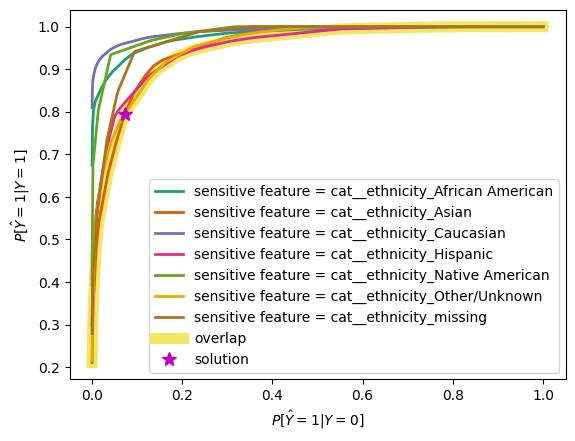

In [29]:
from fairlearn.postprocessing import plot_threshold_optimizer

# plot solution
plot_threshold_optimizer(to)